<a href="https://colab.research.google.com/github/Sabya2/Kaggle-July-TPS/blob/main/TPS_July_Air_Pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries and **Data files**

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle data/tabular-playground-series-jul-2021/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle data/tabular-playground-series-jul-2021/test.csv')
sample = pd.read_csv('/content/drive/MyDrive/Kaggle data/tabular-playground-series-jul-2021/sample_submission.csv')

In [ ]:
print("train shape", train.shape)
print("test shape", test.shape)

train shape (7111, 12)
test shape (2247, 9)


**Test** lack three columns namely - '**target_carbon_monoxide**', '**target_benzene**', '**target_nitrogen_oxides**'; these are the one that has be to be predicted based on the other features given in train data.

# Time Analysis:  

## Loading and preparing the data

In [ ]:
# date time has to be change from object to a datetine format, this can be directly done also while importing the data
train['date_time']=pd.to_datetime(train['date_time'])
train.set_index('date_time', inplace = True)

# dataset for univariate analysis
train_u = train.copy()
cols = ['deg_C', 'relative_humidity', 'absolute_humidity',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
train_u.drop(cols, axis = 1, inplace = True)

#renaming the columns
# cm - carbon monoxide; ben = benzene; no = nitrogen oxides
train_u.columns = ["cm", "ben", "no"]

train_u.head()


,cm,ben,no
date_time,,,
2010-03-10 18:00:00,2.5,12.0,167.7
2010-03-10 19:00:00,2.1,9.9,98.9
2010-03-10 20:00:00,2.2,9.2,127.1
2010-03-10 21:00:00,2.2,9.7,177.2
2010-03-10 22:00:00,1.5,6.4,121.8


## Visualize the data
So we have hourly data from 10th march to 1st jan next year. 
* we can extract information or trend based on month, week, day, and hourly 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb61322b650>],
      dtype=object)

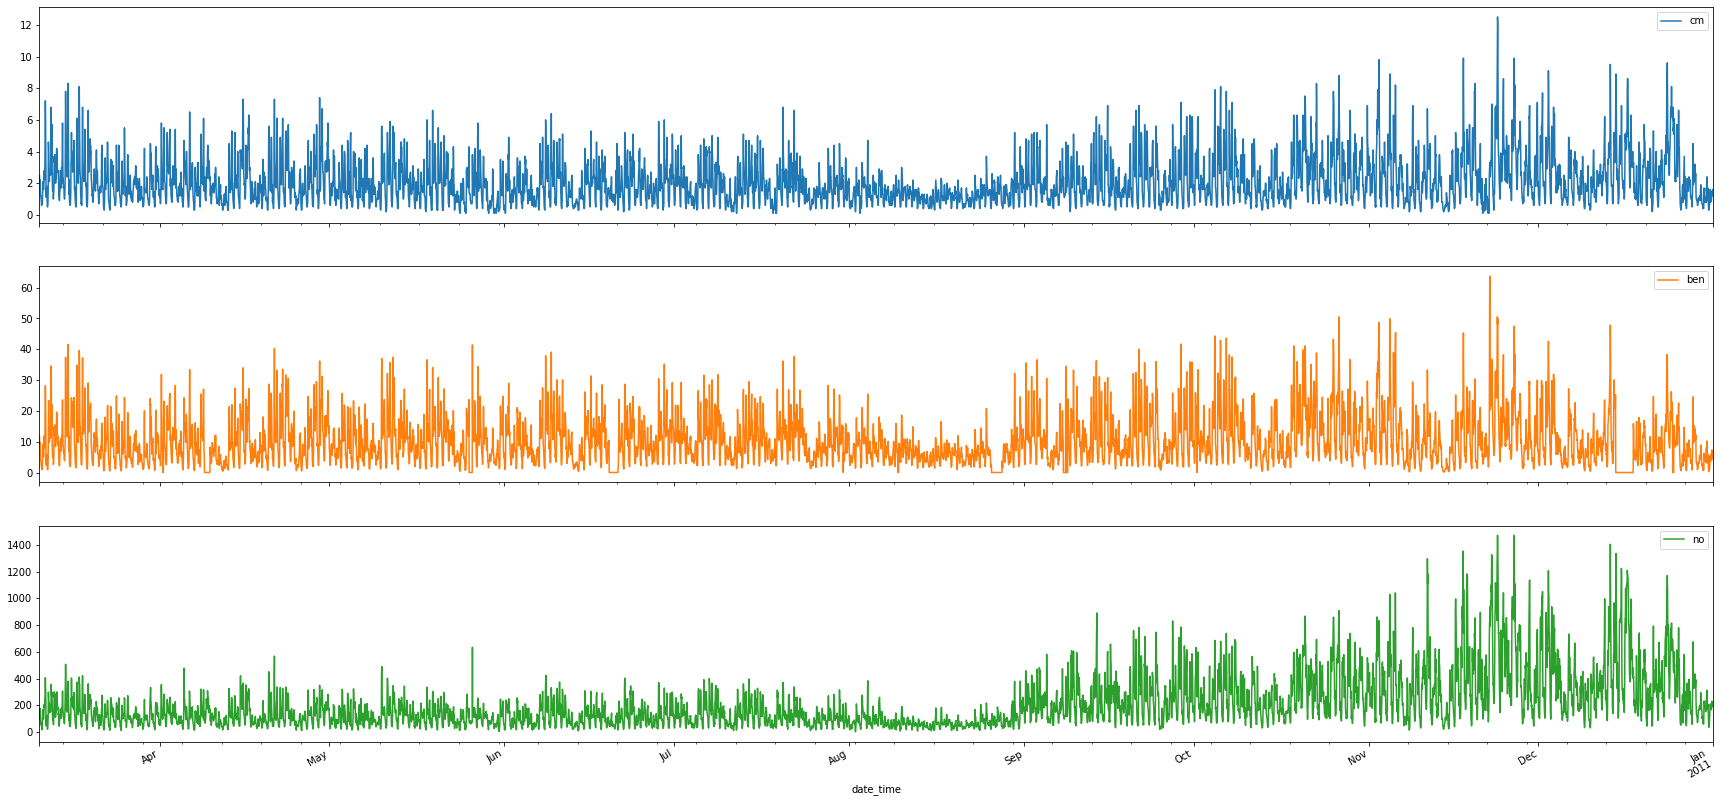

In [ ]:
train_u.plot(
    subplots = True, 
    layout = (3,1), 
    sharex = True, 
    figsize = (30,15) )

Plotting all the target together made me realise that the pollutants all share a same pattern. Toward the end the their respective values have increased, may be an over all increase in the trend. 


In [ ]:
# Separately performing each target variable.

train_cm = train_u.copy()
train_cm.drop(columns = ['ben','no'], inplace = True)
train_cm.head()

,cm
date_time,
2010-03-10 18:00:00,2.5
2010-03-10 19:00:00,2.1
2010-03-10 20:00:00,2.2
2010-03-10 21:00:00,2.2
2010-03-10 22:00:00,1.5


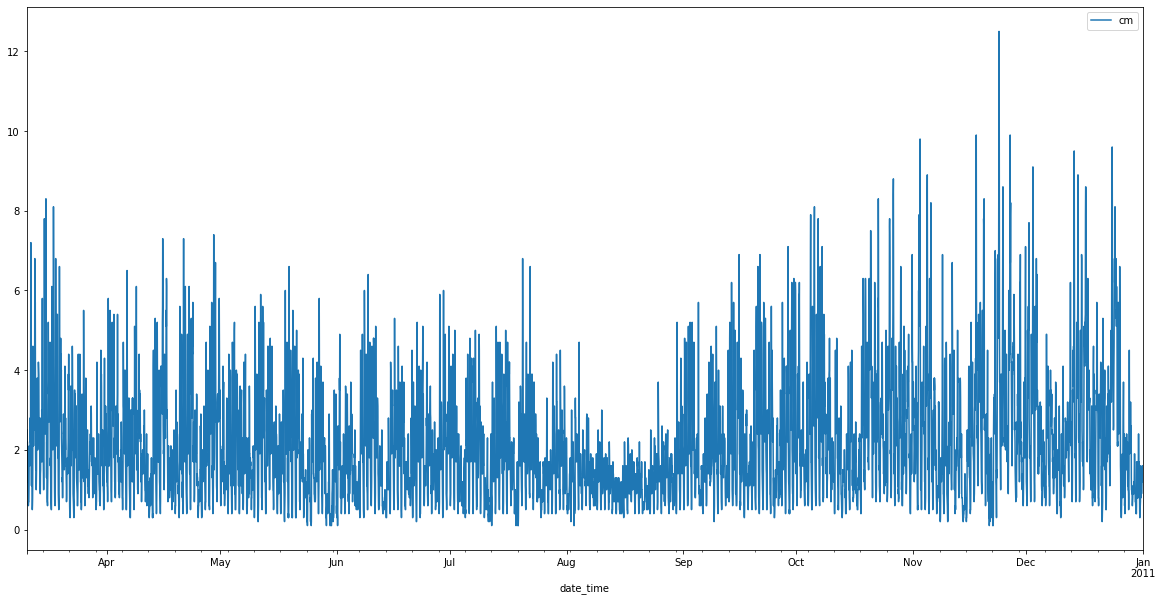

In [ ]:
train_cm.plot(figsize = (20,10))

## Splitting data into its components : 
seasonality, trend and residuals

Additive time series:
Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:
Value = Base Level x Trend x Seasonality x Error


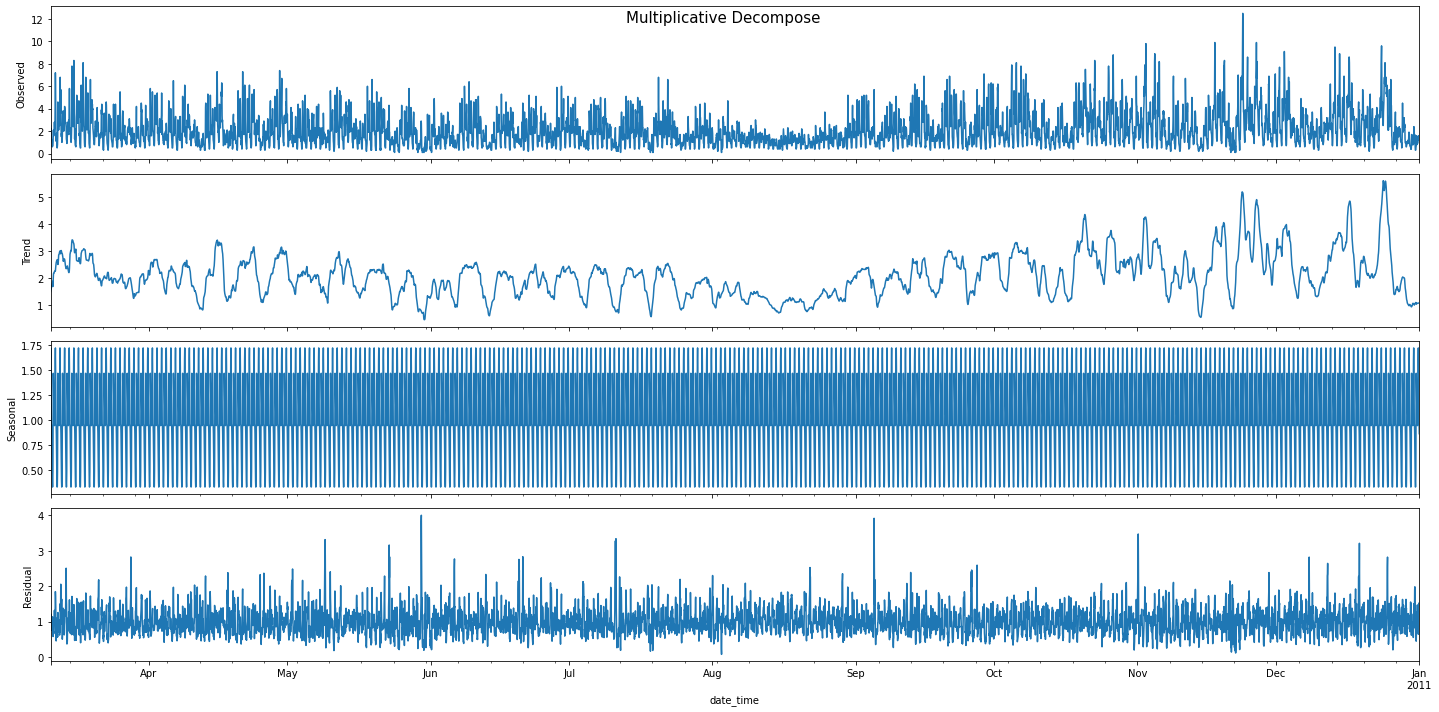

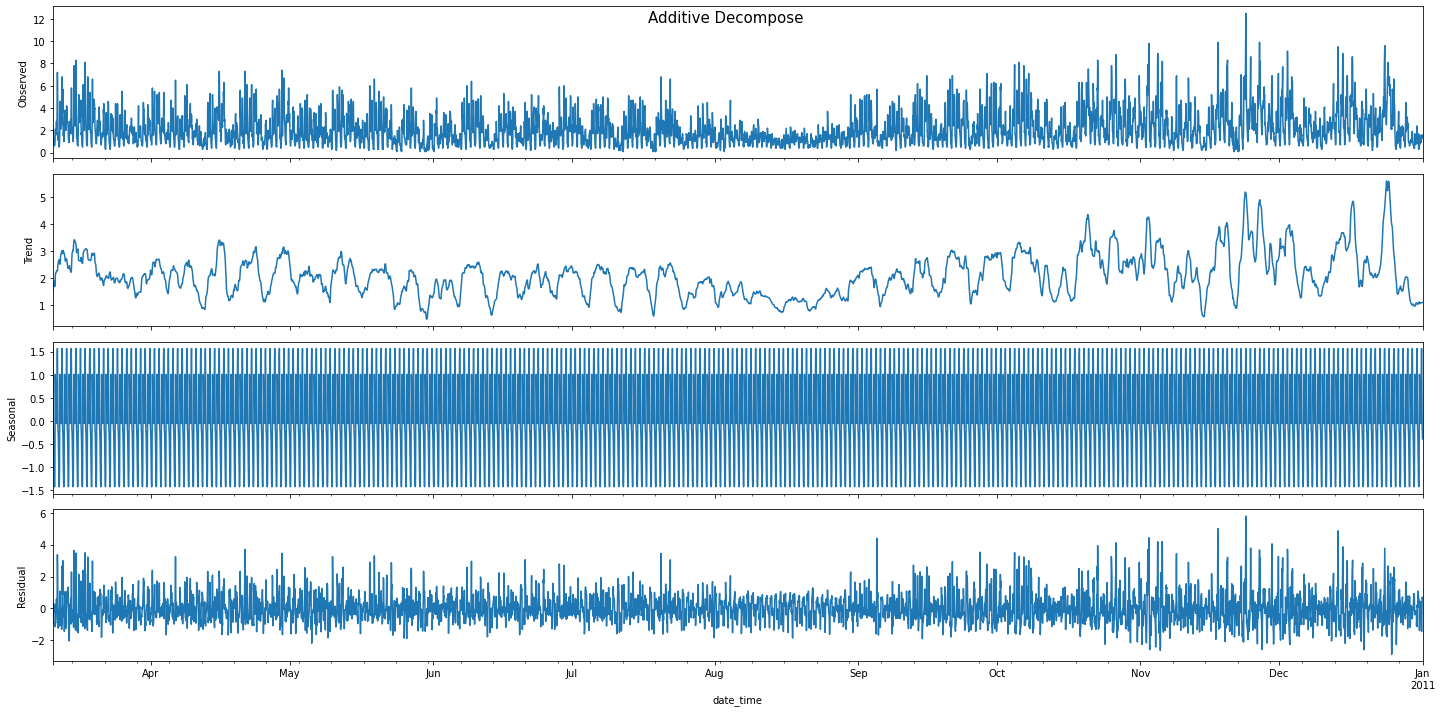

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition
result_mul = seasonal_decompose(train_cm['cm'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(train_cm['cm'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (20,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=15)
result_add.plot().suptitle('Additive Decompose', fontsize=15)
plt.show()

I don't see much difference in the two decompositions. So the either of them can be used. Still need to understand the purpose, why these two methods are available.
* One of the main objectives for a decomposition is to estimate seasonal effects that can be used to create and present seasonally adjusted values. A seasonally adjusted value removes the seasonal effect from a value so that trends can be seen more clearly. https://online.stat.psu.edu/stat510/lesson/5/5.1 

## Stationarity in the data

In [ ]:
# Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [ ]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(levels):
    result=adfuller(levels)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(train_cm['cm'])

ADF Test Statistic : -8.98210258477204
p-value : 7.263413572494878e-15
#Lags Used : 33
Number of Observations Used : 7077
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Since the data showed no stationarity, then **d = 0**, for the future arima moidel.

## AR / MA ? model


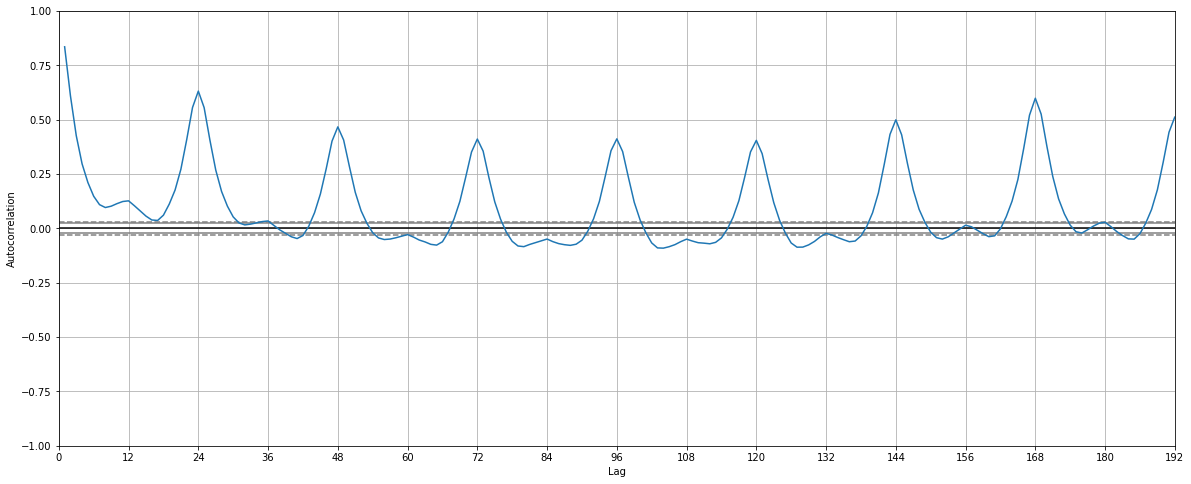

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(20,8))
autocorrelation_plot(train_cm['cm']).set_xlim([0,100]) # setting the limit to a managable level
plt.xticks(np.arange(0, 200, 12)) # changing the tick frequency for matplotlib
plt.show()

* The data is reapeating in a cycle 24.
* Here the acf is pretty high >0.5 for lags well below 500 lags
* The lag value received will be used to get a better ACF and PACF graph
* Each spike that rises above or falls below the dashed lines is considered to be statistically significant. (Chapter 16 talks about this in detail.) This means the spike has a value that is significantly different from zero. If a spike is significantly different from zero, that is evidence of autocorrelation. A spike that’s close to zero is evidence against autocorrelation.
https://www.dummies.com/programming/big-data/data-science/autocorrelation-plots-graphical-technique-for-statistical-data/

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

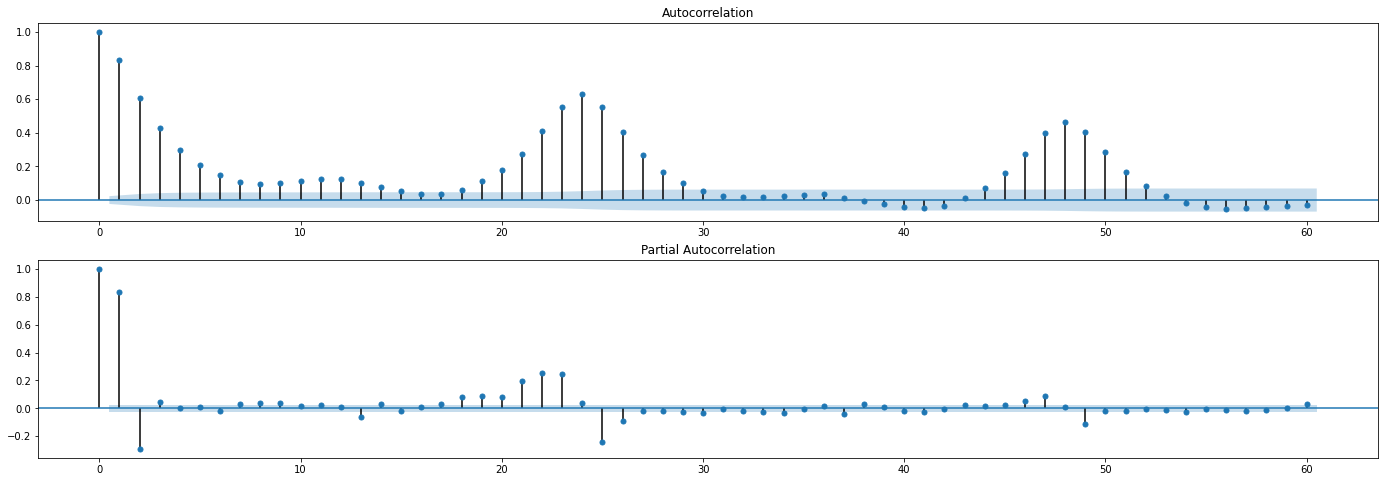

In [ ]:
# AR(p) or MA(q) based on the ACF and PACF graphs

fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_cm['cm'], lags = 60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_cm['cm'],lags=60, ax=ax2)

* From the ACF plot, a seasonality/cyclic nature of 24 is observed, basically the pollutant levels repeats the pattern daily
* PACF = P = 1 or 2 for sure. 
* Need to removed the pattern by differencing in 24 moving window format

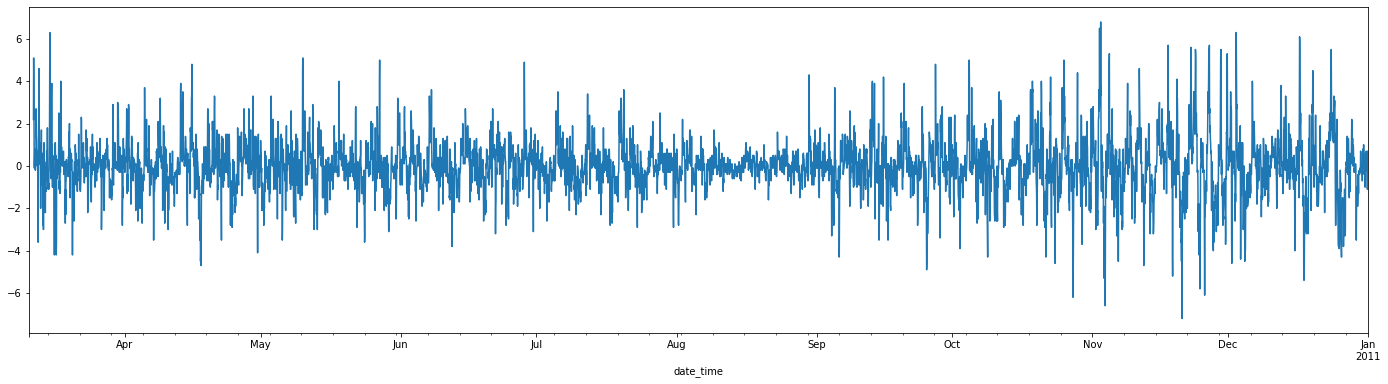

In [ ]:
# train_cm['di'] = train_cm.diff(axis = 0, periods = 24)

train_cm['diff'] = train_cm['cm'] - train_cm['cm'].shift(24)
train_cm['diff'].plot(figsize = (24,6))

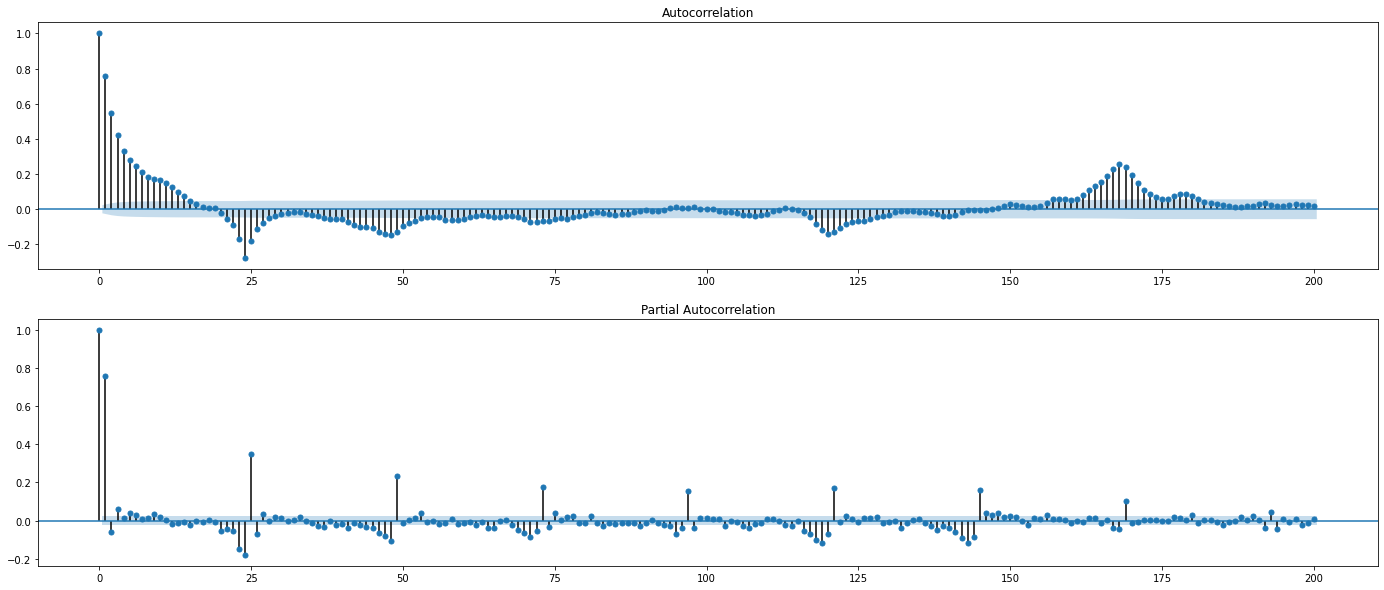

In [ ]:
# post differencing 

fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_cm['diff'].iloc[24:], lags = 200, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_cm['diff'].iloc[24:],lags = 200, ax=ax2)

* AR(p) = can be 1 or strecthed to 2, since post that the correlation values drops
* MA(q) = is 1 since the inertia of that is carried forward to the rest of the values, and it is something that is validated by the ACF plot also.


## ARIMA 2.0

### Selecting the order

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


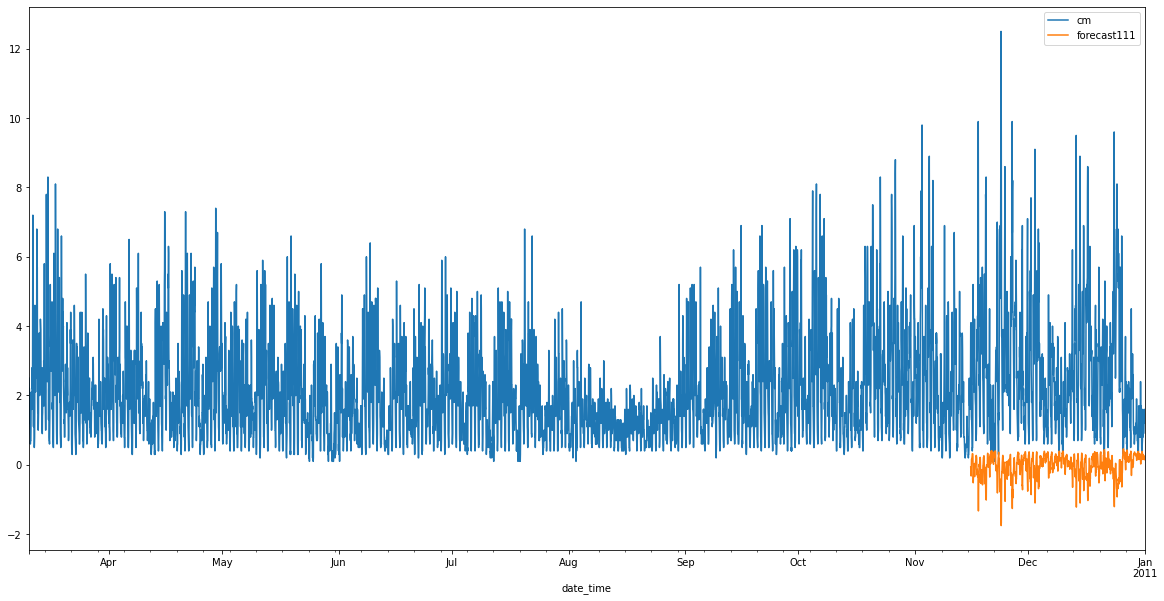

In [ ]:
# arima 111
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(train_cm['cm'],order=(1,1,1))
model_fit = arima_model.fit()
train_cm['forecast111'] = model_fit.predict(start=6000 , end=7110 )
train_cm[['cm','forecast111']].plot(figsize=(20,10))

The fact that forecast is bad proves the initial point of seasonality and the i need to try SARIMA model. 
* Note for this starting project i am just focusing on the traget variables, but in the subsequent notebook will try adding the exogenous variables

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


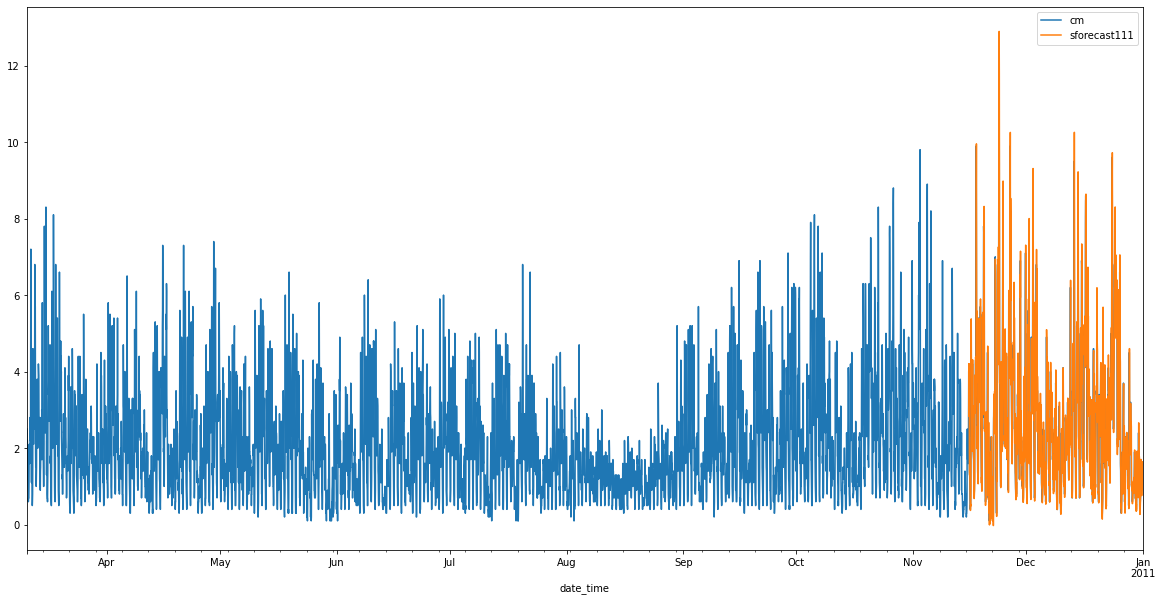

In [ ]:
# sarima 111
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_cm['cm'],order=(1, 1, 1))
model_fit = sarima_model.fit()
train_cm['sforecast111'] = model_fit.predict(start=6000 , end=7110 )
train_cm[['cm','sforecast111']].plot(figsize=(20,10))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


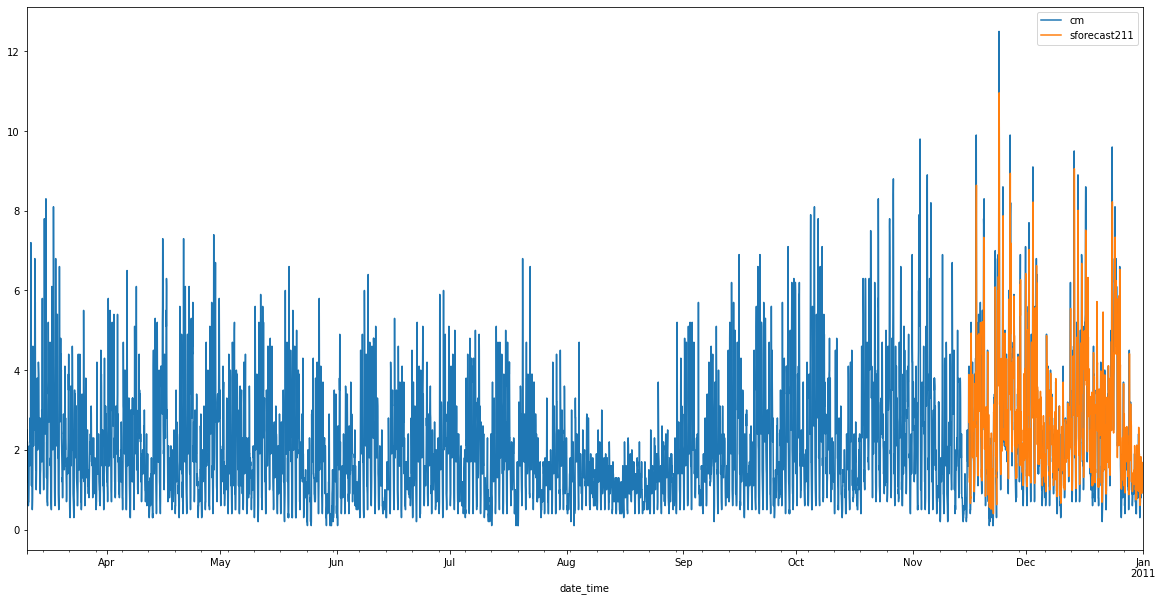

In [ ]:
# sarima 211
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_cm['cm'],order=(2, 1, 1))
model_fit = sarima_model.fit()
train_cm['sforecast211'] = model_fit.predict(start=6000 , end=7110 )
train_cm[['cm','sforecast211']].plot(figsize=(20,10))

Sarima ***111, 211***; all gave promising result. 
* Next step will be to combine all the target variables 
* Combined error for the forecast 
* the best model will be applied on the test csv

### Accuracy test

In [ ]:
train_cm[['cm','sforecast212']].iloc[5999:7111]

,cm,sforecast212
date_time,,
2010-11-15 17:00:00,2.6,NaN
2010-11-15 18:00:00,4.0,2.727923
2010-11-15 19:00:00,3.9,3.901925
2010-11-15 20:00:00,4.1,3.356279
2010-11-15 21:00:00,2.4,3.649924
...,...,...
2010-12-31 20:00:00,1.3,1.257071
2010-12-31 21:00:00,1.4,1.467208
2010-12-31 22:00:00,1.6,1.531138


Mean Absolute Percentage Error (MAPE) 
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))

In [ ]:
train_cm.columns

Index(['cm', 'diff', 'forecast212', 'forecast111', 'sforecast111',
       'sforecast211', 'sforecast212'],
      dtype='object')

In [ ]:
model_111 = np.mean(np.abs(train_cm['forecast111'].iloc[6000:7111] - train_cm['cm'].iloc[6000:7111])/np.abs(train_cm['cm'].iloc[6000:7111]))

model_212 = np.mean(np.abs(train_cm['forecast212'].iloc[6000:7111] - train_cm['cm'].iloc[6000:7111])/np.abs(train_cm['cm'].iloc[6000:7111]))

model_s111 = np.mean(np.abs(train_cm['sforecast111'].iloc[6000:7111] - train_cm['cm'].iloc[6000:7111])/np.abs(train_cm['cm'].iloc[6000:7111]))

model_s211 = np.mean(np.abs(train_cm['sforecast211'].iloc[6000:7111] - train_cm['cm'].iloc[6000:7111])/np.abs(train_cm['cm'].iloc[6000:7111]))

model_s212 = np.mean(np.abs(train_cm['sforecast212'].iloc[6000:7111] - train_cm['cm'].iloc[6000:7111])/np.abs(train_cm['cm'].iloc[6000:7111]))

print(' error - 111',model_111, '\n error - 212', model_212, 
      '\n error - s111', model_s111, '\n error - s211', model_s211, '\n error - s212', model_s212)

 error - 111 0.908085494344588 
 error - 212 0.9134000129033578 
 error - s111 0.2730420835326949 
 error - s211 0.3503506671147382 
 error - s212 0.34856759954058897


least error is observed for seasonal arima with 111 model. There is still room for improvement if the exogenous variables are used 

### Time to predict 

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Kaggle data/tabular-playground-series-jul-2021/test.csv')

# dataset for univariate analysis

cols = ['deg_C', 'relative_humidity', 'absolute_humidity',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
test.drop(cols, axis = 1, inplace = True)
test

,date_time
0,2011-01-01 00:00:00
1,2011-01-01 01:00:00
2,2011-01-01 02:00:00
3,2011-01-01 03:00:00
4,2011-01-01 04:00:00
...,...
2242,2011-04-04 10:00:00
2243,2011-04-04 11:00:00
2244,2011-04-04 12:00:00
2245,2011-04-04 13:00:00


In [ ]:
# cm - sarima 111
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_u['cm'],order=(1, 1, 1))
model_fit = sarima_model.fit()
pre_cm = model_fit.predict(start = pd.to_datetime('2011-01-01 00:00:00'), 
                           end=pd.to_datetime('2011-04-04 14:00:00'), dynamic = False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


predict(start = pd.to_datetime('2011-01-01 00:00:00'), 
                           end=pd.to_datetime('2011-04-04 14:00:00'), dynamic = False)
                           
* the othet way is .forecast(len(df)) \\ but it was deleting data for some weird reasons 

In [ ]:
pre_cm

2011-01-01 00:00:00    1.459063
2011-01-01 01:00:00    1.395532
2011-01-01 02:00:00    1.396463
2011-01-01 03:00:00    1.396269
2011-01-01 04:00:00    1.396309
                         ...   
2011-04-04 10:00:00    1.396302
2011-04-04 11:00:00    1.396302
2011-04-04 12:00:00    1.396302
2011-04-04 13:00:00    1.396302
2011-04-04 14:00:00    1.396302
Freq: H, Length: 2247, dtype: float64

In [ ]:
# ben - sarima 111
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_u['ben'],order=(1, 1, 1))
model_fit = sarima_model.fit()
pre_ben = model_fit.predict(start = pd.to_datetime('2011-01-01 00:00:00'), 
                           end=pd.to_datetime('2011-04-04 14:00:00'), dynamic = False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [ ]:
pre_ben

In [ ]:
# no - sarima 111
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_u['no'],order=(1, 1, 1))
model_fit = sarima_model.fit()
pre_no = model_fit.predict(start = pd.to_datetime('2011-01-01 00:00:00'), 
                           end=pd.to_datetime('2011-04-04 14:00:00'), dynamic = False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [ ]:
pre_no

In [ ]:
final = pd.DataFrame({'cm':pre_cm, 'ben':pre_ben, 'no':pre_no}).reset_index()
final.columns = ['date_time', 'target_carbon_monoxide','target_benzene', 'target_nitrogen_oxides']
final

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.459063,4.549334,196.101726
1,2011-01-01 01:00:00,1.395532,4.023940,185.477638
2,2011-01-01 02:00:00,1.396463,4.040030,185.553997
3,2011-01-01 03:00:00,1.396269,4.036626,185.548294
4,2011-01-01 04:00:00,1.396309,4.037347,185.548720
...,...,...,...,...
2242,2011-04-04 10:00:00,1.396302,4.037221,185.548690
2243,2011-04-04 11:00:00,1.396302,4.037221,185.548690
2244,2011-04-04 12:00:00,1.396302,4.037221,185.548690
2245,2011-04-04 13:00:00,1.396302,4.037221,185.548690


* The above data set can be solved with a regression technique or 
forecasting methods. 
* Forcasting method is a time series method with two techniques, Univariate and Multivariate analysis. 
 * The Multivarite Time series analysis considers the effects of other factors present, givoing a multi regression analyssis. 
* I'll be doing both and compare the efficiency.


# Data Analysis

Steps in data analysis will follow these following steps

*   Check out categorical and numerical data
* Check for duplicate data
*   Detect Null values 
*   Explore the data with graphs and plots (following may be )
 * distribution
 * Correlation
 * Box plot to get an idea about the outliers
* Next step would be to get the correlation between these indepnedent and dependent variables
* changes in the data points of dependent and independent data over time.
* Graphs will help tell the kind of model is needed







## Generic data analysis like **Null-Value**; **Data Types**; **Duplicate Data**

In [ ]:
print("train shape", train.shape)
train.describe().T

In [ ]:
print('Data types of the columns \n\n', train.info())
print('\n\n\nTotal Null values\n', train.isnull().sum())

In [ ]:
print('Total Duplicate values\n', train.duplicated().sum())

Total Duplicate values
 0


### *Inference* 1: 
* No Null values
* All except time are continuous variables of float type data
* Obviously there is a regression and time series analysis, which will be dealt accordingly.


## Univariate DA - Histogram and BoxPLot

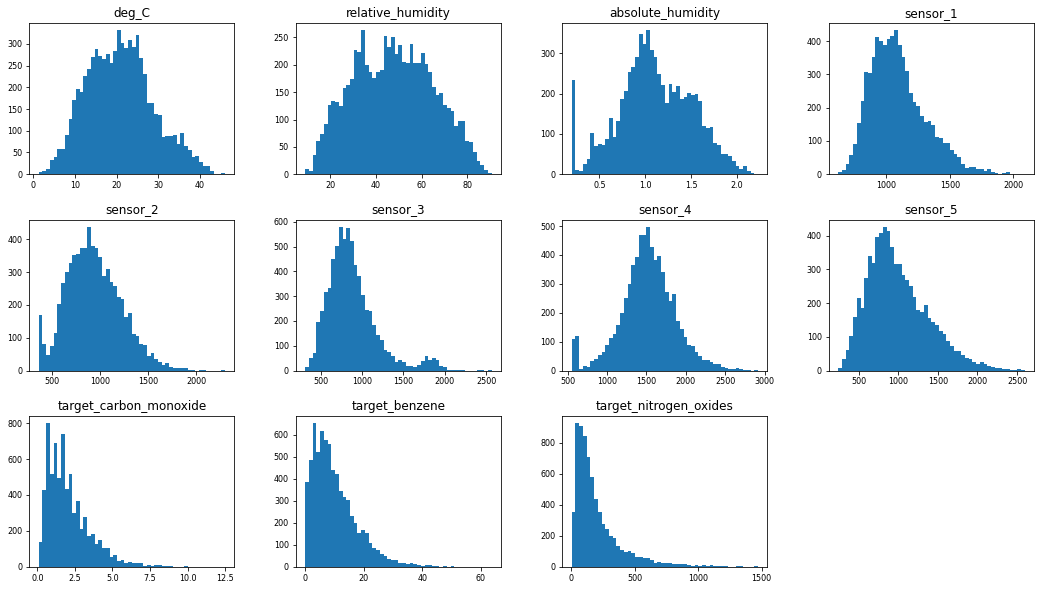

In [ ]:
hist = train.hist(figsize = (18, 10), bins=50, grid = False, xlabelsize=8, ylabelsize=8, layout = (3,4))

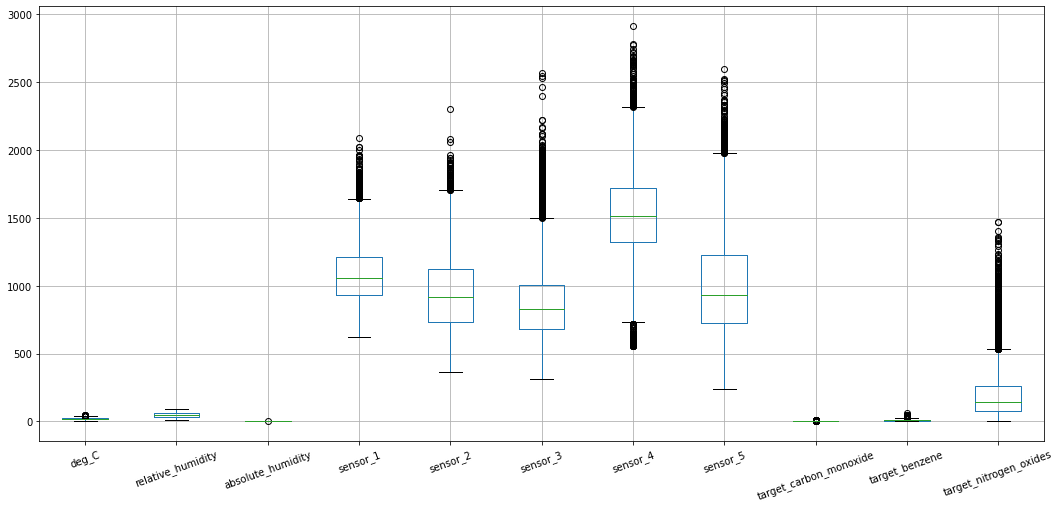

In [ ]:
box = train.boxplot(figsize = (18,8), rot = 20 )

### *Inference* 2: 
* From histogram - Data is normally distributed, except the target ones mostly right skewed.
* From Box-plot - Outliers in all the sensor data, thus a outlier sensitive model has to be picked.
* The data all are in different scales, thus have to be scaled accordingly.
* Because of outliers, **Robust scaler** will be used for scaling.


## Bivariate DA - 

* Comparing the 3 target features with each of the independent features

In [ ]:
train.columns

Index(['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1',
       'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
       'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


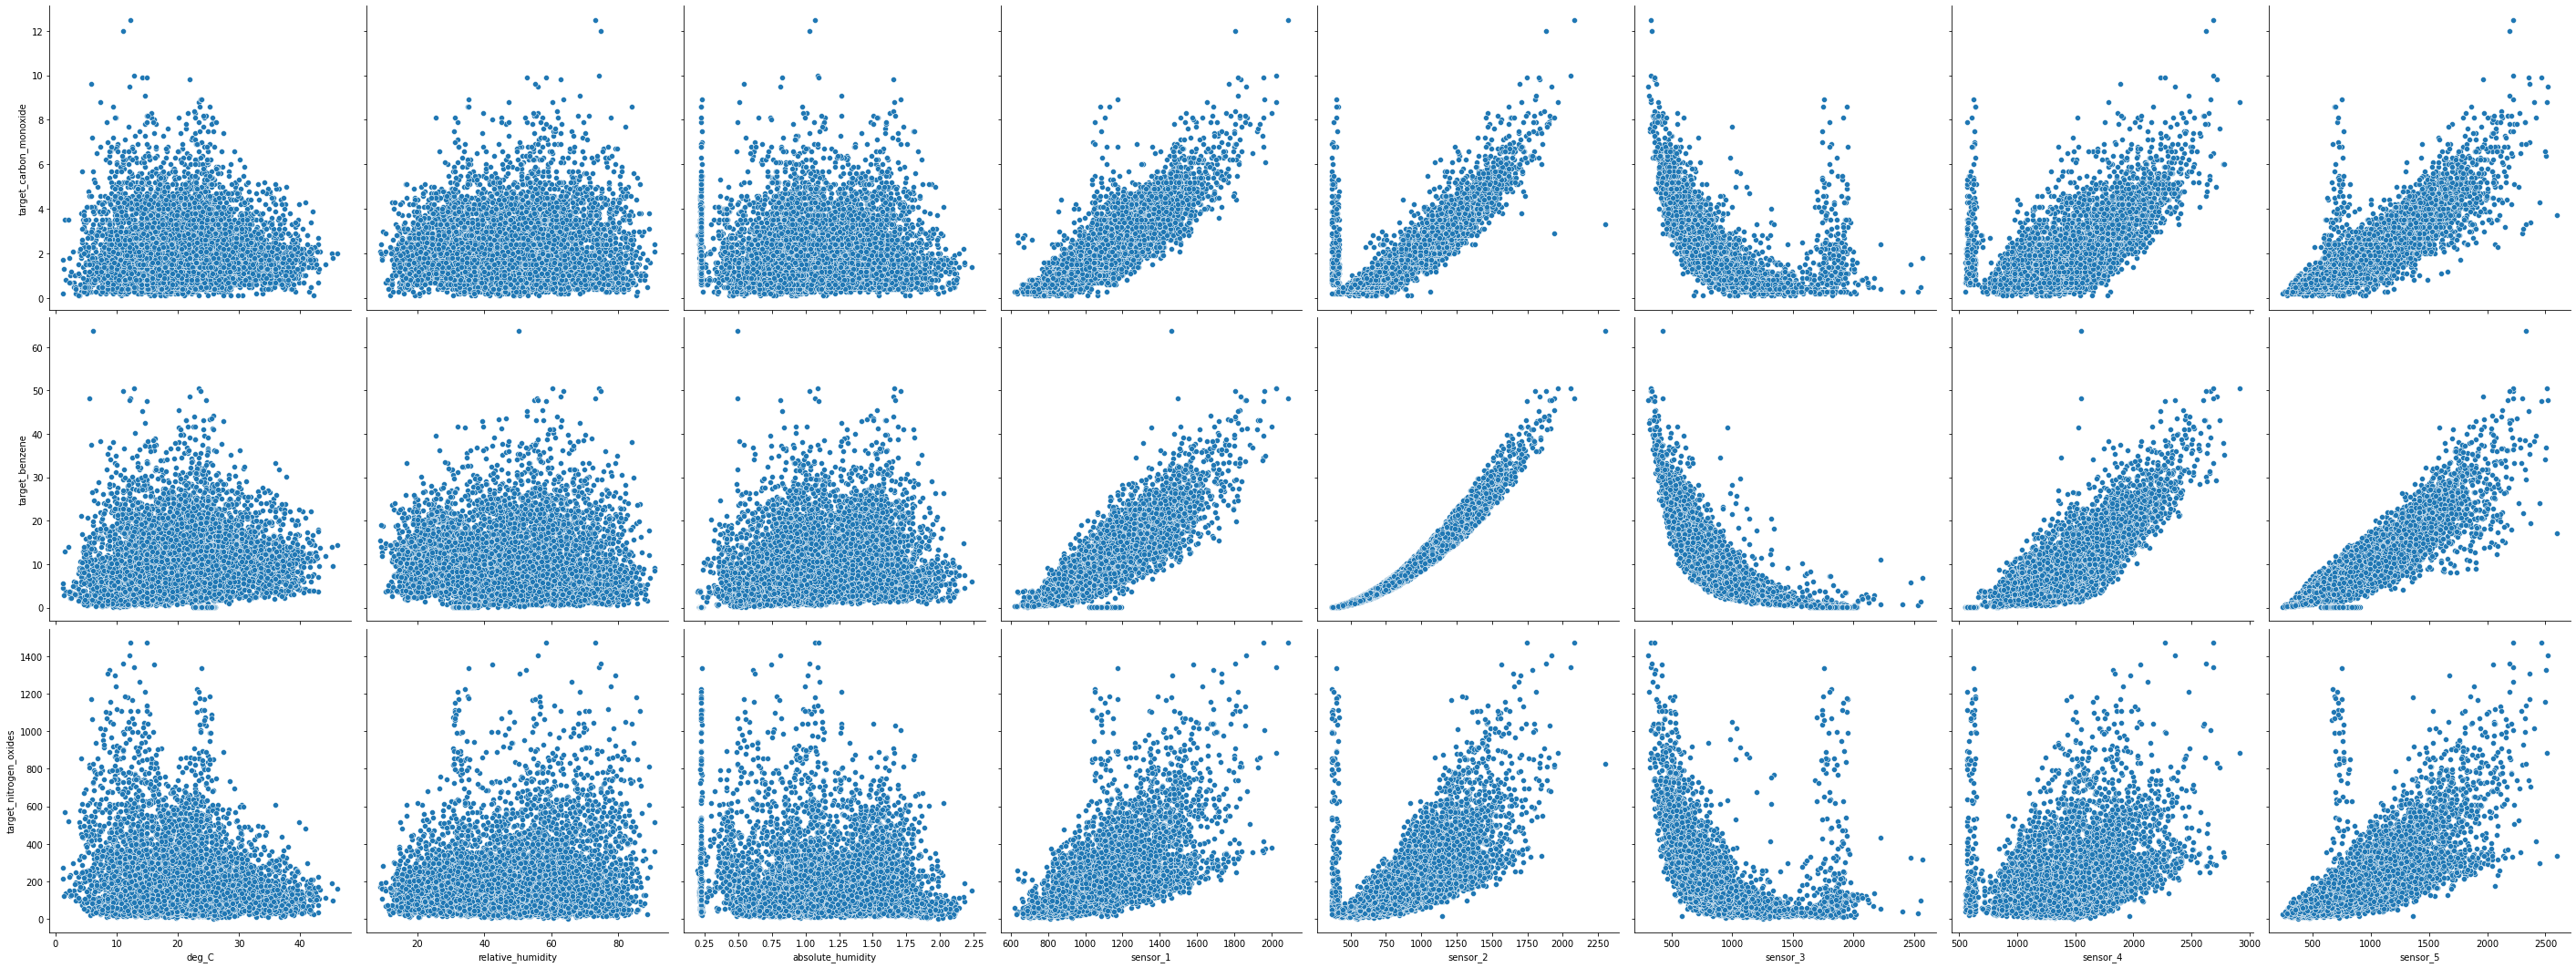

In [ ]:
sns.pairplot(train, size = 5, 
    x_vars=['deg_C', 'relative_humidity', 'absolute_humidity','sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'],
    y_vars=['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'], 
)

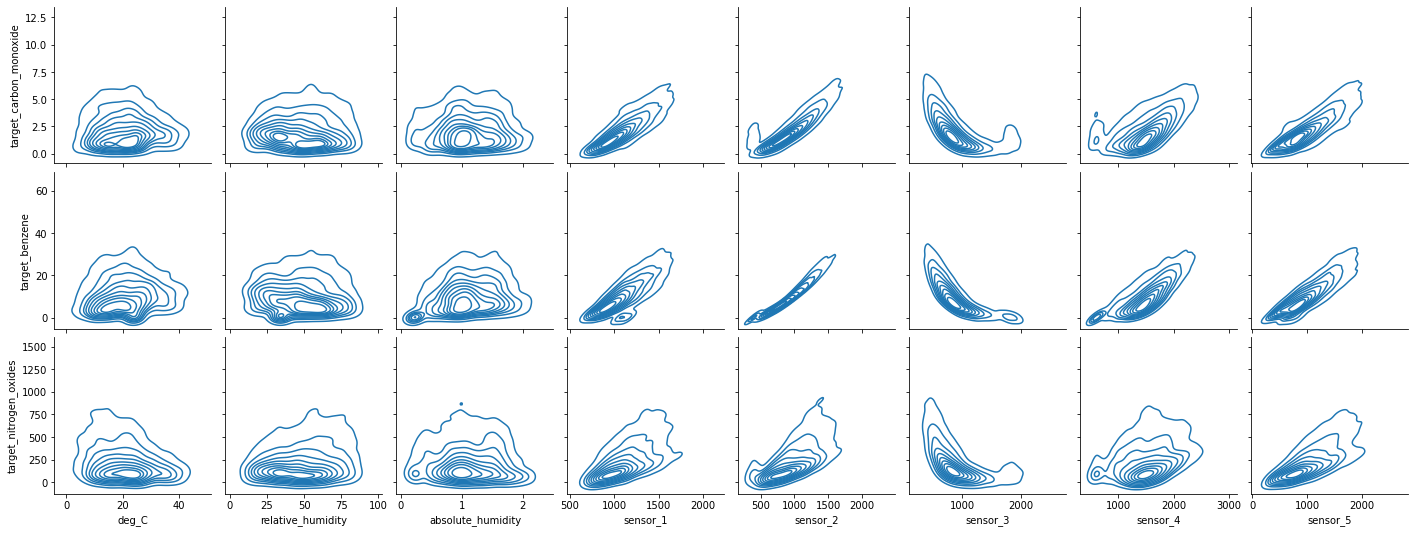

In [ ]:
sns.pairplot(train,
    x_vars=['deg_C', 'relative_humidity', 'absolute_humidity','sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'],
    y_vars=['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'], kind = 'kde',
)

Inference - 3
* Comparing the variables, it is clear that sensors have some sort of linear relation with each of the target varibales. 
* Deg-c,, humidity might have some relation that is observed over time. sice there is repeatation of data points based on the kde plot


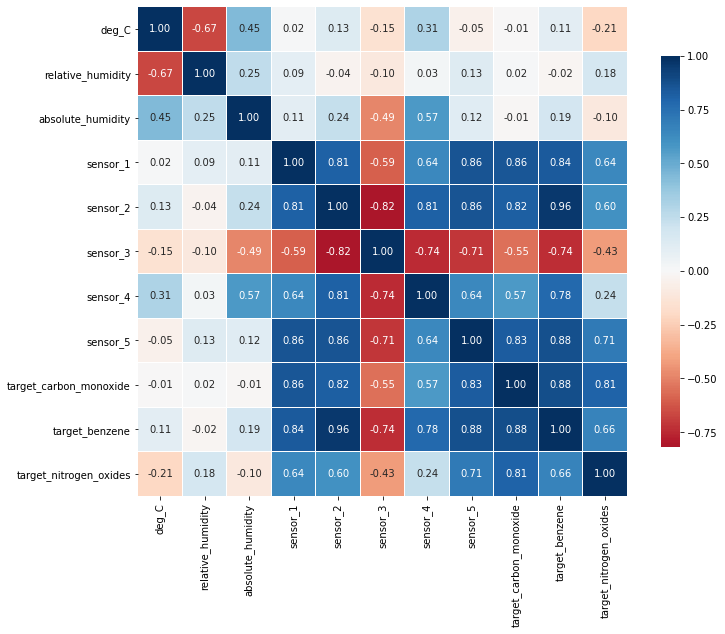

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(train.corr(), annot=True, cmap="RdBu", fmt='.2f', center = 0, linewidths=0.1, cbar_kws={"shrink": .8}, square = True) 

### Inference 4
* Deg-c; humidity are less correlated with the target varibalesa and less with the other inpdependent variables 
* Surprisingly some variables are negatively correlated with the target variables
* There is Multi-collinearity among the variables, thus for prediction - I'll perform **Ridge and Lasso regression.** 
* I'll compare the model(s) acuuracy  and also with and w/o the deg-c, humidity data

# Model Plan

## Steps
* Remove the date time column 
* train-test split before scaling to prevent data leakage
* Scale the test and train data seprately with Robust scalar transformation
* Perform Ridge and lasso Regression 
* Perform Accuracy with the split data 
* Final prediction 

### Data Preparation

In [ ]:
m_train = train.copy()
m_train.drop(['date_time'], axis = 1, inplace = True)

In [ ]:
m_train

In [ ]:
m_train.columns

Index(['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1',
       'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
       'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'],
      dtype='object')

### Splitting and Scaling Data

In [ ]:
# separating the Target from the independent varibales
x_data = m_train.drop(['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'],axis=1)
y_data = m_train[['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']]


# Splitting the data into train and test data 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=10)
print("X-train shape", x_train.shape, "\n Y-test shape" ,y_test.shape)

X-train shape (5688, 8) 
 Y-test shape (1423, 3)


In [ ]:
# Scaling the data 
# Robust Scaling

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler() # class object
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns = x_test.columns)


In [ ]:
y_train.columns

Index(['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'], dtype='object')

### Target Carbon-Monoxide Model Creation 

In [ ]:
# Ridge Model Creation of Robust scaled data:
from sklearn.linear_model import Ridge
ridge = Ridge(fit_intercept = False, normalize = False)
ridge.fit(x_train,y_train['target_carbon_monoxide'])
ridge_predict = ridge.predict(x_test)
print('Ridge score: of Robust scaled data: w/o intercept, w/o normalised ', ridge.score(x_test,y_test['target_carbon_monoxide']))
print('Error: ', np.mean(np.abs(ridge_predict - y_test['target_carbon_monoxide'])/       
                     np.abs(y_test['target_carbon_monoxide'])))
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_carbon_monoxide'],ridge_predict))


# Ridge Model Creation of Robust scaled data: w/normalisation
from sklearn.linear_model import Ridge
ridge = Ridge(fit_intercept = True, normalize = True)
ridge.fit(x_train,y_train['target_carbon_monoxide'])
ridge_predict = ridge.predict(x_test)
print('\nRidge score: of Robust scaled data: w/intercept, w/normalisation', ridge.score(x_test,y_test['target_carbon_monoxide']))
print('Error: ', np.mean(np.abs(ridge_predict - y_test['target_carbon_monoxide'])/       
                     np.abs(y_test['target_carbon_monoxide'])))
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_carbon_monoxide'],ridge_predict))


# Ridge Model Creation of Robust scaled data: w/normalisation
from sklearn.linear_model import Ridge
ridge = Ridge(fit_intercept = True, normalize = False)
ridge.fit(x_train,y_train['target_carbon_monoxide'])
ridge_predict = ridge.predict(x_test)
print('\nRidge score: of Robust scaled data: w/intercept, w/o normalisation', ridge.score(x_test,y_test['target_carbon_monoxide']))
print('Error: ', np.mean(np.abs(ridge_predict - y_test['target_carbon_monoxide'])/       
                     np.abs(y_test['target_carbon_monoxide'])))
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_carbon_monoxide'],ridge_predict))

Ridge score: of Robust scaled data: w/o intercept, w/o normalised  -0.3282074864761355
Error:  1.0523317481522214
MSE: 2.5862756549081944

Ridge score: of Robust scaled data: w/intercept, w/normalisation 0.7696805834104774
Error:  0.3492160194613641
MSE: 0.44847624037906175

Ridge score: of Robust scaled data: w/intercept, w/o normalisation 0.8450842183775643
Error:  0.277033773507219
MSE: 0.3016508479666505


In [ ]:
# Splitting the data into train and test data for non scaled data modelling
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.2, random_state=10)
print("X-train1 shape", x_train1.shape, "*--x--*" ,  "Y-test1 shape" ,y_test1.shape)


# Ridge Model Creation of non scaled data
from sklearn.linear_model import Ridge
ridge = Ridge(fit_intercept = False, normalize = False)
ridge.fit(x_train1,y_train1['target_carbon_monoxide'])
ridge_predict = ridge.predict(x_test1)
print('\nRidge score: of non scaled data: w/o intercept, w/o normalised', ridge.score(x_test1,y_test1['target_carbon_monoxide']))
print('Error: ', np.mean(np.abs(ridge_predict - y_test['target_carbon_monoxide'])/       
                     np.abs(y_test['target_carbon_monoxide'])))
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_carbon_monoxide'],ridge_predict))


# Ridge Model Creation of non scaled data: w/normalisation
from sklearn.linear_model import Ridge
ridge = Ridge(fit_intercept = True, normalize = True)
ridge.fit(x_train1,y_train1['target_carbon_monoxide'])
ridge_predict = ridge.predict(x_test1)
print('\nRidge score: of non scaled data: w/intercept, w/normalisation', ridge.score(x_test1,y_test1['target_carbon_monoxide']))
print('Error: ', np.mean(np.abs(ridge_predict - y_test['target_carbon_monoxide'])/       
                     np.abs(y_test['target_carbon_monoxide'])))
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_carbon_monoxide'],ridge_predict))

X-train1 shape (5688, 8) *--x--* Y-test1 shape (1423, 3)

Ridge score: of non scaled data: w/o intercept, w/o normalised 0.7983803061468832
Error:  0.3276659328460219
MSE: 0.39259235554062544

Ridge score: of non scaled data: w/intercept, w/normalisation 0.7651898809408584
Error:  0.35132429531876824
MSE: 0.4572205025435715


Its safe to assume that robust scaling gives a better R2 value compared to the rest of the other factors, so i'll go with the robust scaled data with no normalisation, and intercept present


In [ ]:
# selecting alpha for ridge regression using RidgeCV

# Ridge Model Creation of Robust scaled data: w/normalisation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas = [0.1, 1.0, 10.0, 15.0, 20.0, 40.0], fit_intercept = True, 
                store_cv_values = True, normalize = False, cv=None)
ridge.fit(x_train,y_train['target_carbon_monoxide'])
ridge_predict = ridge.predict(x_test)
print('Ridge cv score: of Robust scaled data: w/intercept, w/o normalisation', ridge.score(x_test,y_test['target_carbon_monoxide']))
print('best ridge.alpha_' , ridge.alpha_)
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_carbon_monoxide'],ridge_predict))

Ridge cv score: of Robust scaled data: w/intercept, w/o normalisation 0.845084218378163
best ridge.alpha_ 1.0
MSE: 0.3016508479654846


### Target benzene model Creation

In [ ]:
# Ridge Model Creation of Robust scaled data: for 'target_benzene'

from sklearn.linear_model import Ridge
ridge = Ridge(fit_intercept = False, normalize = False)
ridge.fit(x_train,y_train['target_benzene'])
ridge_predict = ridge.predict(x_test)
print('Ridge score: of Robust scaled data: w/o intercept, w/o normalised ', ridge.score(x_test,y_test['target_benzene']))
print('Error: ', np.mean(np.abs(ridge_predict - y_test['target_benzene'])/       
                     np.abs(y_test['target_benzene'])))
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_benzene'],ridge_predict))


# Ridge Model Creation of Robust scaled data: w/normalisation
from sklearn.linear_model import Ridge
ridge = Ridge(fit_intercept = True, normalize = True)
ridge.fit(x_train,y_train['target_benzene'])
ridge_predict = ridge.predict(x_test)
print('\nRidge score: of Robust scaled data: w/intercept, w/normalisation', ridge.score(x_test,y_test['target_benzene']))
print('Error: ', np.mean(np.abs(ridge_predict - y_test['target_benzene'])/       
                     np.abs(y_test['target_benzene'])))
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_benzene'],ridge_predict))


# Ridge Model Creation of Robust scaled data: w/normalisation
from sklearn.linear_model import Ridge
ridge = Ridge(fit_intercept = True, normalize = False)
ridge.fit(x_train,y_train['target_benzene'])
ridge_predict = ridge.predict(x_test)
print('\nRidge score: of Robust scaled data: w/intercept, w/o normalisation', ridge.score(x_test,y_test['target_benzene']))
print('Error: ', np.mean(np.abs(ridge_predict - y_test['target_benzene'])/       
                     np.abs(y_test['target_benzene'])))
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_benzene'],ridge_predict))

Ridge score: of Robust scaled data: w/o intercept, w/o normalised  -0.07026520085907983
Error:  1.9574668195520595
MSE: 60.769421295675315

Ridge score: of Robust scaled data: w/intercept, w/normalisation 0.8824120257976514
Error:  0.4829393359556305
MSE: 6.676619157449735

Ridge score: of Robust scaled data: w/intercept, w/o normalisation 0.9536775648022799
Error:  0.4061686330269145
MSE: 2.630177621128235


### Target Nitrogen Oxide - Model Creation

In [ ]:
# Ridge Model Creation of Robust scaled data: for 'target_nitrogen_oxides'

from sklearn.linear_model import Ridge
ridge = Ridge(fit_intercept = False, normalize = False)
ridge.fit(x_train,y_train['target_nitrogen_oxides'])
ridge_predict = ridge.predict(x_test)
print('Ridge score: of Robust scaled data: w/o intercept, w/o normalised ', ridge.score(x_test,y_test['target_nitrogen_oxides']))
print('Error: ', np.mean(np.abs(ridge_predict - y_test['target_nitrogen_oxides'])/       
                     np.abs(y_test['target_nitrogen_oxides'])))
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_nitrogen_oxides'],ridge_predict))


# Ridge Model Creation of Robust scaled data: w/normalisation
from sklearn.linear_model import Ridge
ridge = Ridge(fit_intercept = True, normalize = True)
ridge.fit(x_train,y_train['target_nitrogen_oxides'])
ridge_predict = ridge.predict(x_test)
print('\nRidge score: of Robust scaled data: w/intercept, w/normalisation', ridge.score(x_test,y_test['target_nitrogen_oxides']))
print('Error: ', np.mean(np.abs(ridge_predict - y_test['target_nitrogen_oxides'])/       
                     np.abs(y_test['target_nitrogen_oxides'])))
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_nitrogen_oxides'],ridge_predict))


# Ridge Model Creation of Robust scaled data: w/normalisation
from sklearn.linear_model import Ridge
ridge = Ridge(fit_intercept = True, normalize = False)
ridge.fit(x_train,y_train['target_nitrogen_oxides'])
ridge_predict = ridge.predict(x_test)
print('\nRidge score: of Robust scaled data: w/intercept, w/o normalisation', ridge.score(x_test,y_test['target_nitrogen_oxides']))
print('Error: ', np.mean(np.abs(ridge_predict - y_test['target_nitrogen_oxides'])/       
                     np.abs(y_test['target_nitrogen_oxides'])))
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_nitrogen_oxides'],ridge_predict))

Ridge score: of Robust scaled data: w/o intercept, w/o normalised  0.1537226782224026
Error:  1.3861561935214788
MSE: 30146.74448216666

Ridge score: of Robust scaled data: w/intercept, w/normalisation 0.5282497923822598
Error:  0.6053575640533176
MSE: 16805.050309735903

Ridge score: of Robust scaled data: w/intercept, w/o normalisation 0.6867953068473505
Error:  0.6077419398080749
MSE: 11157.21952143926


Look more into the target nitrogen oxide - 
* The MAPE error is impartial to scale of the variables
* The MSE is effected by the scale and thus probably scaling down the vartiables the error value will be reduced significantly 

#### Fixing Nitrogen prediction


In [ ]:
# selecting alpha for ridge regression using RidgeCV

# Ridge Model Creation of Robust scaled data: w/normalisation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas = [0.1, 1.0, 10.0, 15.0, 20.0, 40.0], fit_intercept = True, 
                store_cv_values = True, normalize = False, cv=None)
ridge.fit(x_train,y_train['target_nitrogen_oxides'])
ridge_predict = ridge.predict(x_test)
print('Ridge cv score: of Robust scaled data: w/intercept, w/o normalisation', ridge.score(x_test,y_test['target_nitrogen_oxides']))
print('best ridge.alpha_' , ridge.alpha_)
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(y_test['target_nitrogen_oxides'],ridge_predict))


Ridge cv score: of Robust scaled data: w/intercept, w/o normalisation 0.6867953068481003
best ridge.alpha_ 1.0
MSE: 11157.21952141254


In [ ]:
# Lets rescale the target variables
no_train = y_train.copy()
no_test = y_test.copy()
no_train.drop(columns = ['target_carbon_monoxide', 'target_benzene'], inplace = True)
no_test.drop(columns = ['target_carbon_monoxide', 'target_benzene'], inplace = True)

In [ ]:
# Robust Scaling the no_train and no_test data 

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler() # class object
no_train = pd.DataFrame(scaler.fit_transform(no_train), columns = no_train.columns)
no_test = pd.DataFrame(scaler.fit_transform(no_test), columns = no_test.columns)

In [ ]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas = [0.1, 1.0, 10.0, 15.0, 20.0, 40.0], fit_intercept = True, 
                store_cv_values = True, normalize = False, cv=None)
ridge.fit(x_train,no_train['target_nitrogen_oxides'])
ridge_predict = ridge.predict(x_test)
print('Ridge cv score: of Robust scaled data: w/intercept, w/o normalisation', ridge.score(x_test,no_test['target_nitrogen_oxides']))
print('best ridge.alpha_' , ridge.alpha_)
print('Error: ', np.mean(np.abs( (ridge_predict - no_test['target_nitrogen_oxides']) 
                        /no_test['target_nitrogen_oxides'])))

from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(no_test['target_nitrogen_oxides'],ridge_predict))


Ridge cv score: of Robust scaled data: w/intercept, w/o normalisation 0.6872567169905088
best ridge.alpha_ 1.0
Error:  inf
MSE: 0.3343120520071711


# Final regression model

* parameters are Alpha = 1, which is by default 1; Normalise = false; Fit_intercept = true

In [ ]:
test.drop(columns = 'date_time', inplace = True)


,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3
...,...,...,...,...,...,...,...,...
2242,23.2,28.7,0.7568,1340.3,1023.9,522.8,1374.0,1659.8
2243,24.5,22.5,0.7119,1232.8,955.1,616.1,1226.1,1269.0
2244,26.6,19.0,0.6406,1187.7,1052.4,572.8,1253.4,1081.1
2245,29.1,12.7,0.5139,1053.2,1009.0,702.0,1009.8,808.5


In [ ]:
sample.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,2.0,10.0,300.0
1,2011-01-01 01:00:00,2.0,10.0,300.0
2,2011-01-01 02:00:00,2.0,10.0,300.0
3,2011-01-01 03:00:00,2.0,10.0,300.0
4,2011-01-01 04:00:00,2.0,10.0,300.0


In [ ]:
# Scaling the data 
# Robust Scaling of the test data, since my model is based on scaled features

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler() # class object
test = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)

In [ ]:
# Final Ridge Model; 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'

from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 1.0, fit_intercept = True, normalize = False)
ridge.fit(x_train,y_train['target_carbon_monoxide'])
sample['target_carbon_monoxide'] = ridge.predict(test)

ridge.fit(x_train,y_train['target_benzene'])
sample['target_benzene'] = ridge.predict(test)

ridge.fit(x_train,y_train['target_nitrogen_oxides'])
sample['target_nitrogen_oxides'] = ridge.predict(test)

In [ ]:
sample

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,2.005990,8.431852,237.046272
1,2011-01-01 01:00:00,2.903200,12.466275,369.941095
2,2011-01-01 02:00:00,2.341902,11.369407,309.006365
3,2011-01-01 03:00:00,2.533825,12.557259,306.986190
4,2011-01-01 04:00:00,2.080941,10.524081,262.995998
...,...,...,...,...
2242,2011-04-04 10:00:00,3.390270,16.668507,288.933591
2243,2011-04-04 11:00:00,2.804235,13.908580,228.486241
2244,2011-04-04 12:00:00,2.933939,15.630849,235.792111
2245,2011-04-04 13:00:00,2.615394,13.755017,253.100673
